# Translating Plate at 60°

In [1]:
using VortexModel

import VortexModel.Vortex
import Vortex.Sheets: arclength
import Vortex.Plates.force

## Set up plotting

The specifics of how we plot the figures are not important.  We will be using [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl), but you can use any plotting package you like.

In [2]:
@static if isinteractive()
    using PyPlot
    function plot_system(sys)
        plate, (sheet₊, sheet₋) = sys
        plot(real.(plate.zs[[1,plate.N]]), imag.(plate.zs[[1,plate.N]]), "k")
        plot(real.(sheet₊.zs), imag.(sheet₊.zs), 
             linewidth = 1, color="#e41a1c")
        plot(real.(sheet₋.zs), imag.(sheet₋.zs), 
             linewidth = 1, color="#377eb8")
        axis(:scaled)
    end
    function plot_forces(T, forces)
        subplot(211)
        plot(T, -2real.(forces), linewidth = 2, color="#1f77b4")
        ylabel("\$C_D\$")
        axis([extrema(T)..., 0, 10])
        tick_params(labelbottom="off") 
        subplot(212)
        plot(T, 2imag.(forces), linewidth = 2, color="#1f77b4")
        ylabel("\$C_L\$")
        axis([extrema(T)..., 0, 10])
        xlabel("Time")
    end
else
    plot_system(sys) = nothing
    plot_forces(T, forces) = nothing
end

plot_forces (generic function with 1 method)

## Time Marching

At every time-step, before computing the self induced velocity of the system, we must first enforce the no-flow-through condition on the plate.  So the velocity function for time marching is:

In [3]:
function compute_ẋ!(ẋ, x, t)
    plate, ambient_sys = x
    motion = ẋ[1]
    
    Vortex.Plates.enforce_no_flow_through!(plate, motion, ambient_sys)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x)
end

compute_ẋ! (generic function with 1 method)

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [4]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
    
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Vortex.Plates.enforce_no_flow_through!(plate, motion, (sheet₊, sheet₋))
    
    Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux!(plate, segment₊, segment₋, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

## Initialize plate and sheets

We are simulating a flat plate with zero thickness impulsively translating horizontally:

In [5]:
L = 2.0   # chord length
ċ = 0.5L  # translation velocity
α = π/3   # angle of attack

N = 128   # number of plate control points

Δt = 1e-2; # time step

We discretize the shear layers as vortex sheets, and assume that the Kutta condition is enforced at both edges of the plate.

In [6]:
δ = 0.2
lesp = tesp = 0.0

0.0

We place the initial segments of the vortex sheet perpendicular to the edges of the plate

In [7]:
plate = Vortex.Plate(N, L, zero(Complex128), α)
motion = Vortex.Plates.Motion(ċ, 0.0)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, motion, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

ambient_sys = (sheet₊, sheet₋)
sys = (plate, ambient_sys)
sys₊ = deepcopy(sys) # Used for storage during time-marching
ẋs = (motion, allocate_velocity(ambient_sys));

forces = Complex128[];

### Forward-Euler

We apply filtering on both the leading and trailing edge vortex sheets, and use the Kutta condition on both edges to determine the strength of new vortex segments:

In [8]:
tf = 9.0
for t in 0.0:Δt:tf
    
    plate, ambient_ω = sys
    motion, ambient_u = ẋs
    
    forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    # The force requires information about the motion of the plate,
    # the strength, location, and velocity of the ambient vortex elements,
    # as well as the vorticity flux from the plate edges
    push!(forces, force(plate, motion, ambient_ω, ambient_u,
            (ambient_ω[1].blobs[end], ambient_ω[2].blobs[end]), Δt))
    
    sys₊, sys = sys, sys₊
    
    for s in 1:2
        arclength(sys[2][s]) ≥ 3Δt && Vortex.Sheets.filter!(sys[2][s], 3Δt, 6Δt)
    end
    
    shed_new_vorticity!(sys[2][1], sys[2][2], sys[1], ẋs[1], lesp, tesp)
end

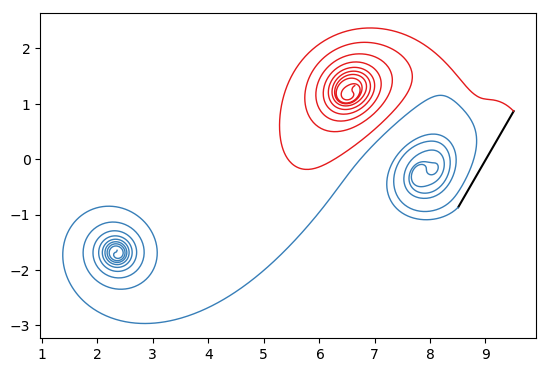

In [9]:
plot_system(sys);

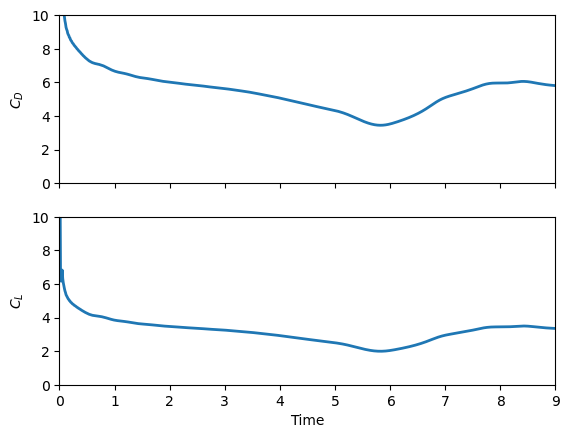

In [10]:
plot_forces(0:Δt:tf, forces);